In [1]:
"""Test the package of orthogonal polynomials using aribitary measure. Link: https://github.com/j-jith/orthopoly#id1"""
import torch
import numpy as np
import numpy.polynomial.polynomial as nppoly
import scipy.integrate as integrate
from ortho2sig import OrthoPoly, Sig2path
import signatory
from free_lie_algebra import *
from experiment_script.main_funcs import fbm_generator
import matplotlib.pyplot as plt
from experiment_script.main_funcs import random_trig_generator
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import time

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Orthogonal polynomials

In [2]:
# Legendre polynomial
pdf_l = lambda z: 1.0
intlims = [-1, 1]
order = 10
pp = OrthoPoly(pdf_l, intlims=intlims)
pp.gen_poly(order)

pp.poly

[array([0.70710678]),
 array([0.        , 1.22474487]),
 array([-0.79056942,  0.        ,  2.37170825]),
 array([ 0.        , -2.80624304,  0.        ,  4.67707173]),
 array([ 0.79549513,  0.        , -7.95495129,  0.        ,  9.2807765 ]),
 array([  0.        ,   4.39726477,   0.        , -20.52056895,
          0.        ,  18.46851205]),
 array([ -0.7967218 ,   0.        ,  16.73115778,   0.        ,
        -50.19347334,   0.        ,  36.80854711]),
 array([   0.        ,   -5.99071547,    0.        ,   53.91643925,
           0.        , -118.61616636,    0.        ,   73.42905537]),
 array([   0.79720045,    0.        ,  -28.69921636,    0.        ,
         157.84568997,    0.        , -273.59919594,    0.        ,
         146.57099783]),
 array([   0.        ,    7.58511879,    0.        , -111.24840896,
           0.        ,  433.86879494,    0.        , -619.8125642 ,
           0.        ,  292.68926643]),
 array([-7.97434891e-01,  0.00000000e+00,  4.38589190e+01,  0.000

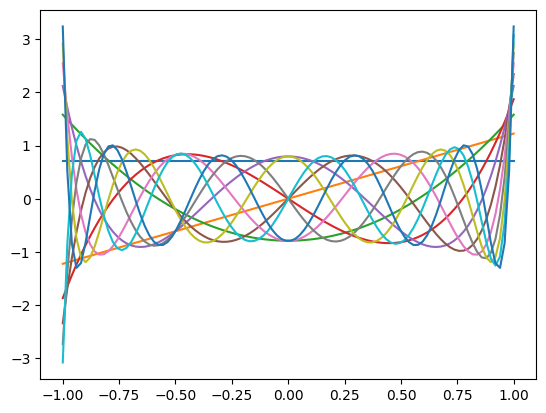

In [3]:
xx = np.linspace(-1, 1, 100)
for p_i in pp.poly:
    plt.plot(xx, nppoly.polyval(xx, p_i))
plt.show()

In [4]:
# test coefficients of orthogonal polynomials
coeff_order = 15
t_grid = np.linspace(-1, 1, 200)
example_path = lambda t: np.cos(15*t) - np.sin(3*t) - (np.cos(-15) - np.sin(-3))
print(pp.a(example_path, coeff_order)-pp.a(example_path(t_grid), coeff_order))

[ 1.16157978e-04 -5.83264050e-05  2.71071113e-04 -6.68644536e-05
  3.99098428e-04 -3.36237049e-05  5.46328473e-04  4.54781760e-05
  7.28196057e-04  1.76014279e-04  9.53955123e-04  3.63413967e-04
  1.23005433e-03  6.12680880e-04  1.56109474e-03  9.28267759e-04]


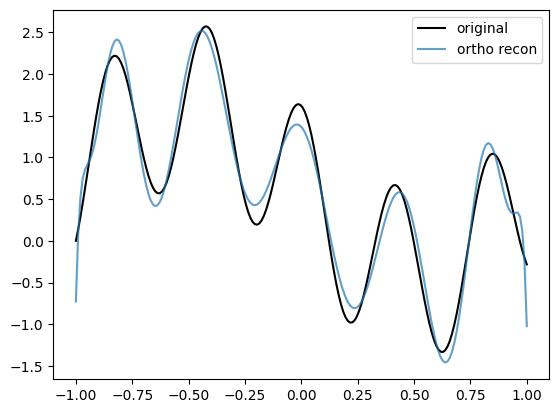

In [5]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, pp.path_eval(t_grid, example_path(t_grid), coeff_order), label='ortho recon', alpha=0.7)
plt.legend()

In [6]:
# scaled Hermite polynomial
pdf_h = lambda z: np.exp(-z**2/2/0.05)
intlims = [-1, 1]
order = 10
pp = OrthoPoly(pdf_h, intlims=intlims)
pp.gen_poly(order)

pp.poly

[array([1.33571626]),
 array([0.        , 5.97398863]),
 array([-0.94514521,  0.        , 18.90596697]),
 array([ 0.        , -7.34650596,  0.        , 49.02966688]),
 array([  0.82867653,   0.        , -33.2804813 ,   0.        ,
        111.48218939]),
 array([   0.        ,    8.49788585,    0.        , -114.80157988,
           0.        ,  233.3603546 ]),
 array([  -0.79416586,    0.        ,   48.94191812,    0.        ,
        -337.14035184,    0.        ,  468.13901774]),
 array([   0.        ,   -9.94559612,    0.        ,  209.91302497,
           0.        , -896.57821377,    0.        ,  925.58713208]),
 array([ 7.93622660e-01,  0.00000000e+00, -6.85590568e+01,  0.00000000e+00,
         7.51658135e+02,  0.00000000e+00, -2.23928757e+03,  0.00000000e+00,
         1.82878488e+03]),
 array([    0.        ,    11.55082216,     0.        ,  -346.48795804,
            0.        ,  2389.40296973,     0.        , -5367.27060694,
            0.        ,  3625.00016211]),
 array([-7.

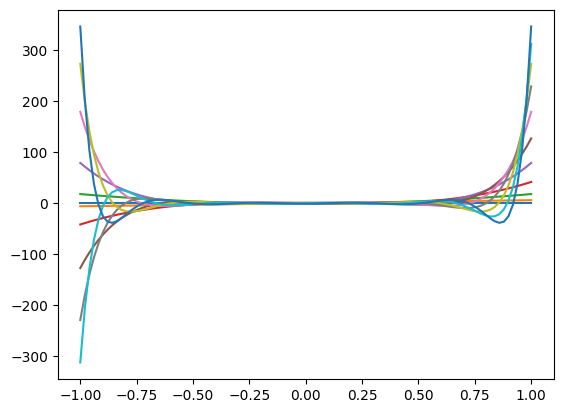

In [7]:
xx = np.linspace(-1, 1, 100)
for p_i in pp.poly:
    plt.plot(xx, nppoly.polyval(xx, p_i))
plt.show()

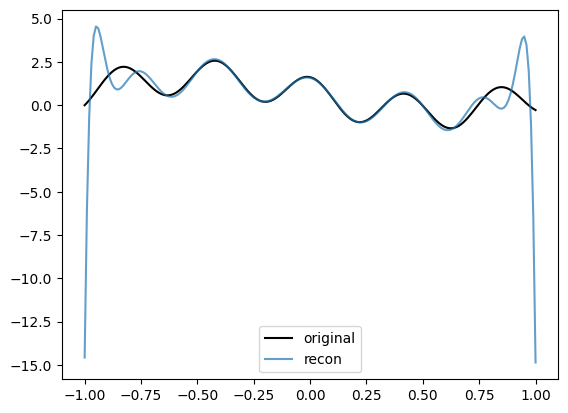

In [8]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, pp.path_eval(t_grid, example_path(t_grid), coeff_order), label='recon', alpha=0.7)
plt.legend()

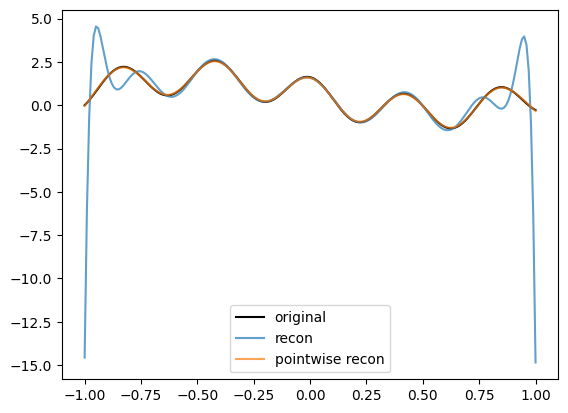

In [9]:
# pointwise reconstruction
def pdf_hermite(t, params):
    t0, eps = params
    return np.exp(-(t-t0)**2/2/eps**2) / eps

pointwise_order = 3
pointwise_poly = np.zeros_like(t_grid)

for i, t in enumerate(t_grid):
    hermite = OrthoPoly(pdf_hermite, margs=[t, 0.05])
    pointwise_poly[i] = hermite.path_eval(t, example_path, pointwise_order)

plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, pp.path_eval(t_grid, example_path, coeff_order), label='recon', alpha=0.7)
plt.plot(t_grid, pointwise_poly, label='pointwise recon', alpha=0.7)
plt.legend()

### Fourier series

In [10]:
def a(t_grid, path, N):
    P = t_grid[-1] - t_grid[0]
    a_arr = np.zeros(N+1)
    a_arr[0] = np.trapz(path, t_grid)/P
    for n in range(1, N+1):
        a_arr[n] = np.trapz(path*np.cos(2*np.pi*n*t_grid/P), t_grid)
    return a_arr

def b(t_grid, path, N):
    P = t_grid[-1] - t_grid[0]
    b_arr = np.zeros(N+1)
    for n in range(1, N+1):
        b_arr[n] = np.trapz(path*np.sin(2*np.pi*n*t_grid/P), t_grid)
    return b_arr

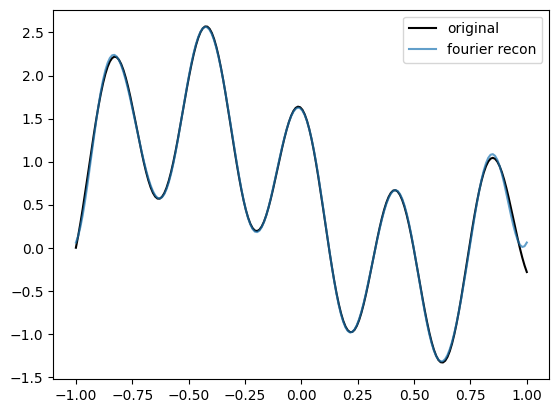

In [11]:
example_path_t = example_path(t_grid)
P = t_grid[-1] - t_grid[0]
a_arr = a(t_grid, example_path(t_grid), order)
b_arr = b(t_grid, example_path(t_grid), order)
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, np.sum([a_arr[n]*np.cos(2*np.pi*n*t_grid/P)+
                         b_arr[n]*np.sin(2*np.pi*n*t_grid/P) for n in range(order+1)], axis=0), label='fourier recon', alpha=0.7)
plt.legend()

### Signatures


##### Orthogonal poly

In [12]:
length = 200
t_grid = np.linspace(-1, 1, length)
N = 15

# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=t_grid)
rec = inv1.path2path(t_grid, example_path(t_grid), N)

In [13]:
a_arr = inv1.poly_class.a(example_path, N)
a_sig = inv1._a_sig(inv1.sig(example_path(t_grid), N), N)
print(a_arr-a_sig)

[ 1.16157978e-04 -6.41456522e-05  1.95683175e-04  4.30941542e-05
  2.12432264e-05 -5.83032891e-06 -4.41150825e-04  3.38806032e-07
 -7.94268633e-04 -1.28650471e-08 -2.18008306e-05  1.03095554e-08
  1.16781017e-03  3.28831437e-07 -1.00429403e-03  5.81331551e-06]


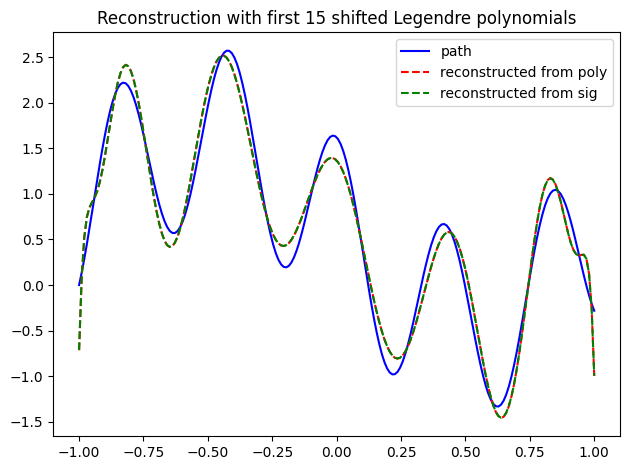

In [14]:
# for p_i in inv1.poly_class.poly:
#     plt.plot(t_grid, nppoly.polyval(t_grid, p_i), alpha=0.3)
plt.plot(t_grid, example_path(t_grid), label='path', c='blue')
plt.plot(t_grid, inv1.poly_class.path_eval(t_grid, example_path, N), label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, rec, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()

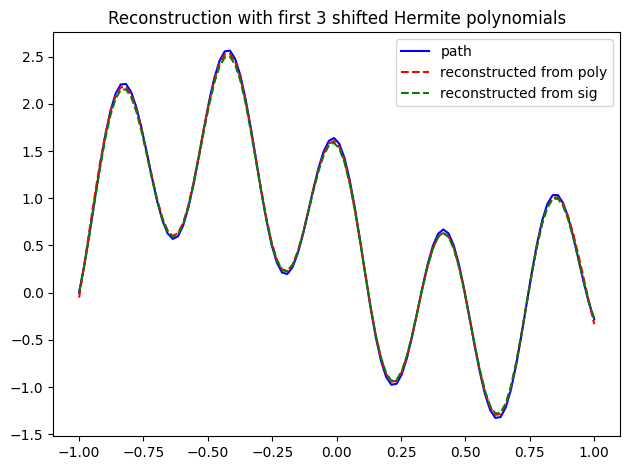

In [15]:
# inversion via Hermite
pointwise_order = 3
t_grid = np.linspace(-1, 1, 100)

pointwise_poly = np.zeros_like(t_grid)
pointwise_sig = np.zeros_like(t_grid)
for i, t in enumerate(t_grid):
    inv2 = Sig2path(pdf_hermite, margs=[t, 0.05])
    pointwise_poly[i] = inv2.poly_class.path_eval(t, example_path, pointwise_order)
    pointwise_sig[i] = inv2.path2path(t, example_path(t_grid), pointwise_order)
    # a_arr = inv2.poly_class.a(example_path, pointwise_order)
    # a_sig = np.array([inv2._a_sig(inv2.sig(example_path(t_grid), pointwise_order), n) for n in range(pointwise_order)])
    # print(a_arr-a_sig)

plt.plot(t_grid, example_path(t_grid), label='path', c='blue')
plt.plot(t_grid, pointwise_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, pointwise_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {pointwise_order} shifted Hermite polynomials')
plt.tight_layout()

##### Fourier series

In [16]:
def chebyshev_T_polynomial(n):
    """Chebyshev polynomial of the first kind."""
    if n == 0:
        return {0: 1}
    elif n == 1:
        return {1: 1}
    else:
        T_prev = chebyshev_T_polynomial(n - 1)
        T_prev2 = chebyshev_T_polynomial(n - 2)
        T = {}

        for power, coeff in T_prev.items():
            T[power + 1] = T.get(power + 1, 0) + 2 * coeff

        for power, coeff in T_prev2.items():
            T[power] = T.get(power, 0) - coeff

        return T

def chebyshev_U_polynomial(n):
    """Chebyshev polynomial of the second kind."""
    if n == 0:
        return {0: 1}
    elif n == 1:
        return {1: 2}
    else:
        U_prev = chebyshev_U_polynomial(n - 1)
        U_prev2 = chebyshev_U_polynomial(n - 2)
        U = {}

        for power, coeff in U_prev.items():
            U[power + 1] = U.get(power + 1, 0) + 2 * coeff

        for power, coeff in U_prev2.items():
            U[power] = U.get(power, 0) - coeff

        return U

def expand_trig_n_theta(n, t0_P=0, key='cos'):
    if key == 'cos':
        expansion = chebyshev_T_polynomial(n)
        expan_sig = {i: 0 for i in range(n+1)}
    elif key == 'sin':
        expansion = chebyshev_U_polynomial(n-1)
        expan_sig = {i: 0 for i in range(n)}
    else:
        raise ValueError("Invalid key. Use 'cos' or 'sin'.")
    for power, coeff in expansion.items():
        for i in range(power+1):
            expan_sig[i] += coeff*np.math.factorial(power)/np.math.factorial(i)/np.math.factorial(power-i)*np.cos(2*np.pi*t0_P)**(power-i)
    return expan_sig

# Example
n = 2
expansion_cos = expand_trig_n_theta(n, -1/2, key='cos')
expansion_sin = expand_trig_n_theta(n, -1/2, key='sin')
print("Cosine expansion:", expansion_cos)
print("Sine expansion (multiplied by sin(theta)):", expansion_sin)

# test
n = 15
t0_P = -1/2
expansion_cos = expand_trig_n_theta(n, t0_P, key='cos')
expansion_sin = expand_trig_n_theta(n, t0_P, key='sin')

t = np.linspace(-10, 10, 100)
e_cos = np.sum([value*(np.cos(t)-np.cos(2*np.pi*t0_P))**key for key, value in expansion_cos.items()], axis=0)
e_sin = np.sum([value*np.sin(t)*(np.cos(t)-np.cos(2*np.pi*t0_P))**key for key, value in expansion_sin.items()], axis=0)
print(np.linalg.norm(np.cos(n*t)-e_cos))
print(np.linalg.norm(np.sin(n*t)-e_sin))

Cosine expansion: {0: 1.0, 1: -4.0, 2: 2.0}
Sine expansion (multiplied by sin(theta)): {0: -2.0, 1: 2.0}
1.4635939007156383e-05
2.3837967636032376e-06


In [40]:
def fourier2sig(sig, N, t, P, t0):
    recon = a_sig(sig, 0, 'cos', P, t0)
    recon_cos = {n: a_sig(sig, n, 'cos', P, t0) for n in range(1, N+1)}
    recon_sin = {n: a_sig(sig, n, 'sin', P, t0) for n in range(1, N+1)}
    for n in range(1, N+1):
        recon += recon_cos[n]*np.cos(2*np.pi*n*t/P) + recon_sin[n]*np.sin(2*np.pi*n*t/P)
    return recon

def l(n, key, P, t0):
    if n==0:
        return 1 / P * word2Elt('41')
    else:
        expansion = expand_trig_n_theta(n, t0/P, key)
        l_n = 0*word2Elt('')
        for power, coeff in expansion.items():
            l_n += coeff*np.math.factorial(power)*word2Elt('2'*power)
        if key=='cos':
            return 2 / P * rightHalfShuffleProduct(shuffleProduct(l_n, word2Elt('4')), word2Elt('1'))
        elif key=='sin':
            return 2 / P * rightHalfShuffleProduct(shuffleProductMany([l_n, word2Elt('3'), word2Elt('4')]), word2Elt('1'))

def a_sig(sig, n, key, P, t0):
    return dotprod(l(n, key, P, t0), sig)

def sig(t_grid, path, N):
    """Compute N+2 truncated signature of time-augmented weighted path."""
    P = t_grid[-1]-t_grid[0]
    path_aug_time = np.c_[t_grid, np.cos(2*np.pi*t_grid/P), np.sin(2*np.pi*t_grid/P), path]
    return signature_of_path_iisignature(path_aug_time, N+2)

In [18]:
N = 10
P = t_grid[-1] - t_grid[0]
path = example_path(t_grid)
recon_path = fourier2sig(sig(t_grid, path, N), N, t_grid, P, t_grid[0])

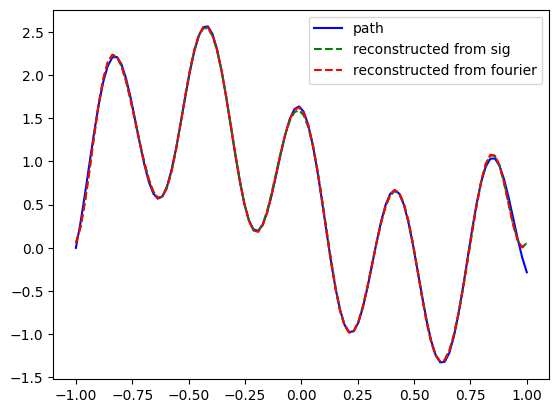

In [19]:
a_arr = a(t_grid, path, N)
b_arr = b(t_grid, path, N)
plt.plot(t_grid, example_path(t_grid), label='path', c='blue')
plt.plot(t_grid, recon_path, label='reconstructed from sig', c='g', linestyle='--')
plt.plot(t_grid, np.sum([a_arr[n]*np.cos(2*np.pi*n*t_grid/P)+
                         b_arr[n]*np.sin(2*np.pi*n*t_grid/P) for n in range(N+1)], axis=0), label='reconstructed from fourier', c='red', linestyle='--')
plt.legend()

### Compare with insertion method
#### 2d cases

In [20]:
## Insertion
# Create a path consisting in a half circle
t_grid = torch.linspace(0, 1, 10)
path = torch.stack([torch.cos(np.pi * t_grid), torch.sin(np.pi * t_grid)]).T.unsqueeze(0)

# Compute the signature
depth = 9
signature = signatory.signature(path, depth)

# Reconstruct the path by inverting the signature
reconstructed_signatory = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])
path.shape

torch.Size([1, 10, 2])

In [21]:
# inversion via legendre
inv_o = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec_o = np.zeros((len(t_grid), 2))
rec_o[:, 0] = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 0], depth-2) + np.array(path)[0, 0, 0]
rec_o[:, 1] = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 1], depth-2) + np.array(path)[0, 0, 1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 200 and the array at index 1 has size 10

In [22]:
# suitable for multi-dimensional path
inv2 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec2 = inv2.path2path(np.array(t_grid), np.array(path)[0], depth-2, dim=2) + np.array(path)[0, 0, :]

In [23]:
# inversion via Fourier
P = t_grid[-1] - t_grid[0]
rec_f = np.zeros((len(t_grid), 2))
rec_f[:, 0] = fourier2sig(sig(np.array(t_grid), np.array(path)[0, :, 0], depth-2), depth-2, np.array(t_grid), np.array(P), np.array(t_grid[0])) + np.array(path)[0, 0, 0]
rec_f[:, 1] = fourier2sig(sig(np.array(t_grid), np.array(path)[0, :, 1], depth-2), depth-2, np.array(t_grid), np.array(P), np.array(t_grid[0])) + np.array(path)[0, 0, 1]

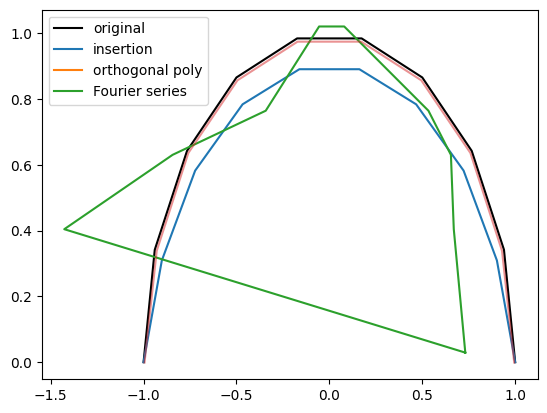

In [24]:
plt.plot(path[0, :, 0], path[0, :, 1], color='black', label='original')
plt.plot(reconstructed_signatory[0, :, 0], reconstructed_signatory[0, :, 1], label='insertion')
plt.plot(rec_o[:, 0], rec_o[:, 1], label='orthogonal poly')
plt.plot(rec_f[:, 0], rec_f[:, 1], label='Fourier series')
plt.plot(rec2[:, 0], rec2[:, 1], alpha=0.5)
plt.legend()

In [25]:
def piecewise_linear_function(x_range, y_values, x):
    """
    Create a piecewise linear function and evaluate it at a specific x value.

    Args:
    x_range (tuple or list): A tuple or list containing the start and end of the x-axis range.
    y_values (list or numpy.ndarray): Y values of the function's control points.
    x (float): The x value at which to evaluate the function.

    Returns:
    float: The y value of the piecewise linear function at the given x.
    """
    # Validate input
    if len(y_values) < 2:
        raise ValueError("y_values must have at least 2 values.")
    
    # Determine the number of segments
    num_segments = len(y_values) - 1
    
    # Calculate the step size along the x-axis
    step_size = (x_range[1] - x_range[0]) / num_segments
    
    # Find the segment in which x falls
    segment_index = int((x - x_range[0]) / step_size)
    
    # Ensure x is within the specified range
    if x < x_range[0] or x > x_range[1]:
        raise ValueError("x is outside the specified x-axis range.")
    
    # Calculate the y value using linear interpolation
    x0 = x_range[0] + segment_index * step_size
    x1 = x_range[0] + (segment_index + 1) * step_size
    y0, y1 = y_values[segment_index], y_values[segment_index + 1]

    y = y0 + (x - x0) * (y1 - y0) / (x1 - x0)
    return y

100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


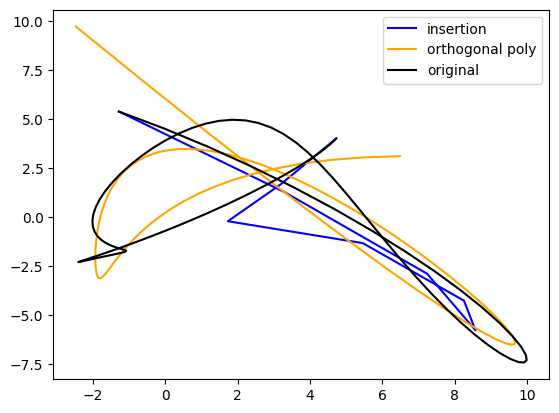

In [26]:
sample_num = 10
max_depth = 8
t_grid = np.linspace(0, 1, 100)

errors = np.zeros((2, max_depth-2))
time_cost = np.zeros((2, max_depth-2))

func_list = []
for _ in range(sample_num):
    func_list.append([random_trig_generator(np.random.randint(1, 10000)), random_trig_generator(np.random.randint(1, 10000))])

for depth in tqdm(range(3, max_depth+1)):
    t = np.linspace(0, 1, depth+1)
    for i in range(sample_num):
        func1, func2 = func_list[i]
        path = np.c_[func1(t_grid), func2(t_grid)]
        path_torch = torch.tensor(path).unsqueeze(0)
        # insertion
        signature = signatory.signature(path_torch, depth)
        start = time.time()
        recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
        end = time.time()
        d1 = integrate.quad(lambda t: (piecewise_linear_function((0, 1), recon_insertion.squeeze(0)[0], t) - func1(t))**2, 0, 1)[0]
        d2 = integrate.quad(lambda t: (piecewise_linear_function((0, 1), recon_insertion.squeeze(0)[1], t) - func2(t))**2, 0, 1)[0]
        errors[0, depth-3] += (d1 + d2) ** 0.5
        time_cost[0, depth-3] += end - start
        # inversion via Legendre polynomials
        inv1 = Sig2path(pdf_l, t_grid=t_grid, depth=depth)
        sig = inv1.sig(path, depth)
        start = time.time()
        rec = inv1.sig2path(t, depth-2, sig=sig, dim=2, return_func=True)
        end = time.time()
        d1 = integrate.quad(lambda t: (path[0, 0] + nppoly.polyval(t, rec[0]) - func1(t))**2, 0, 1)[0]**0.5
        d2 = integrate.quad(lambda t: (path[0, 1] + nppoly.polyval(t, rec[1]) - func2(t))**2, 0, 1)[0]**0.5
        errors[1, depth-3] += (d1 + d2) ** 0.5
        time_cost[1, depth-3] += end - start

errors /= sample_num
time_cost /= sample_num

# # visualsation
plt.plot(np.array(recon_insertion.squeeze(0))[:, 0], np.array(recon_insertion.squeeze(0))[:, 1], color='blue', label='insertion')
plt.plot(path[0, 0] + nppoly.polyval(t_grid, rec[0]), path[0, 1] + nppoly.polyval(t_grid, rec[1]), color='orange', label='orthogonal poly')
plt.plot(path[:, 0], path[:, 1], color='black', label='original')
plt.legend()

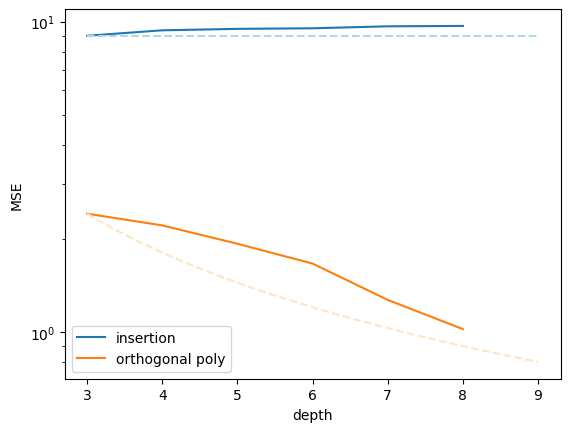

In [27]:
plt.plot(range(3, max_depth+1), errors[0], label='insertion')
plt.plot(np.linspace(3, max_depth+1, 100), errors[0, 0]*np.ones(100), color='lightblue', linestyle='--')
plt.plot(range(3, max_depth+1), errors[1], label='orthogonal poly')
plt.plot(np.linspace(3, max_depth+1, 100), 3*errors[1, 0]*np.linspace(3, max_depth+1, 100)**-1, color='bisque', linestyle='--')
plt.xlabel('depth')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()

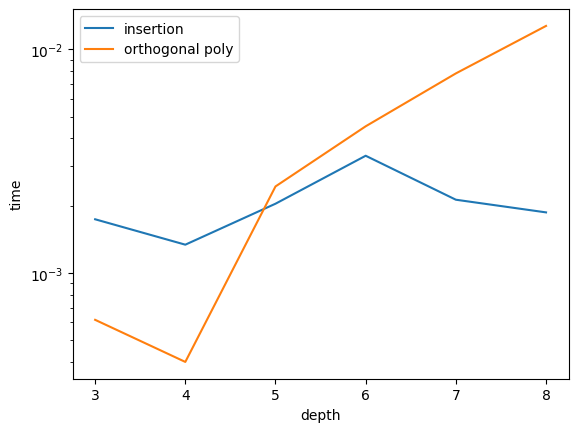

In [28]:
plt.plot(range(3, max_depth+1), time_cost[0], label='insertion')
plt.plot(range(3, max_depth+1), time_cost[1], label='orthogonal poly')
plt.xlabel('depth')
plt.ylabel('time')
plt.yscale('log')
plt.legend()

#### 1d cases

In [29]:
# Create a path consisting in a half circle
t_grid = torch.linspace(0, 1, 50)
path = example_path(t_grid).T.unsqueeze(0).unsqueeze(2)

# Compute the signature
depth = 8
signature = signatory.signature(path, depth)

# Reconstruct the path by inverting the signature
reconstructed_signatory = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])
path.shape

torch.Size([1, 50, 1])

In [30]:
# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 0], depth-2) + np.array(path)[0, 0, 0]

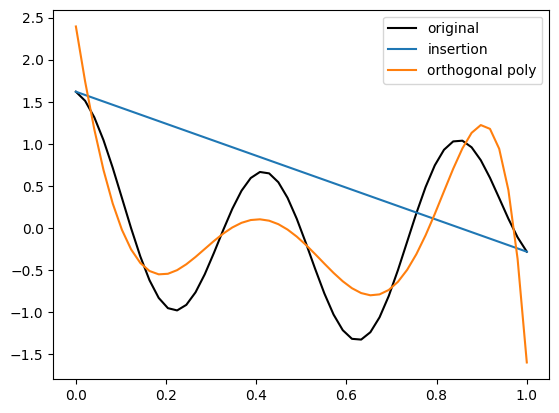

In [31]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(torch.linspace(0, 1, depth+1), reconstructed_signatory[0, :, 0], label='insertion')
plt.plot(t_grid, rec, label='orthogonal poly')
plt.legend()

use time augmented path for both methods

In [32]:
# Create a path consisting in a half circle
t_grid = torch.linspace(0, 1, 100)
path = torch.stack([t_grid, example_path(t_grid)]).T.unsqueeze(0)

# Compute the signature
depth = 8
signature = signatory.signature(path, depth)

# Reconstruct the path by inverting the signature
reconstructed_signatory = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])

In [33]:
# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 1], depth-2) + np.array(path)[0, 0, 1]

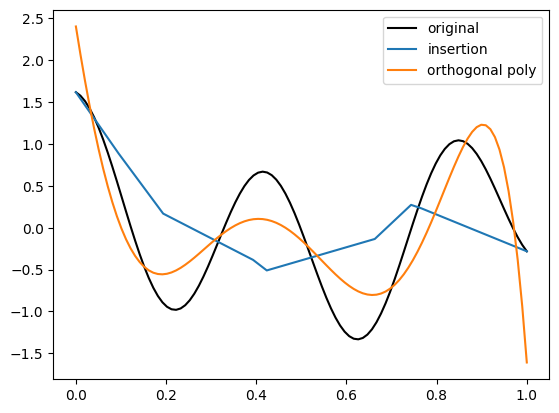

In [34]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(reconstructed_signatory[0, :, 0], reconstructed_signatory[0, :, 1], label='insertion')
plt.plot(t_grid, rec, label='orthogonal poly')
plt.legend()

time-augmented path

compare reconstruction quality and time cost by changing depth and time length

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Besty\AppData\Local\Temp\ipykernel_92144\4151861322.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  errors[0, i, depth-3] += integrate.quad(lambda t: (piecewise_linear_function((0, t_len), recon_insertion, t)
 20%|██        | 2/10 [00:01<00:06,  1.28it/s]C:\Users\Besty\AppData\Local\Temp\ipykernel_92144\4151861322.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  errors[0, i, depth-3] += integrate.quad(lamb

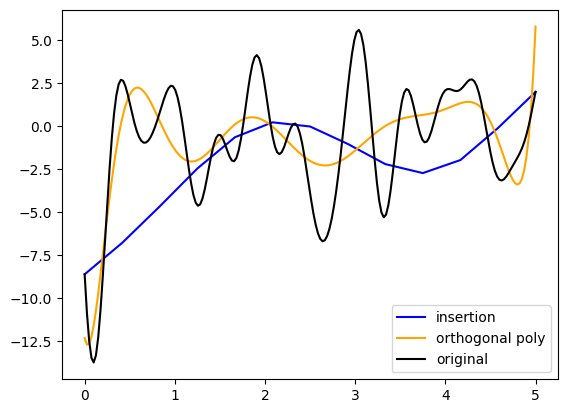

In [35]:
sample_num = 10
max_depth = 12

errors = np.zeros((2, 3, max_depth-2))
time_cost = np.zeros((2, 3, max_depth-2))

func_list = []
for _ in range(sample_num):
    func_list.append(random_trig_generator(np.random.randint(1, 10000)))

for depth in tqdm(range(3, max_depth+1)):
    for i, t_len in enumerate([0.5, 1, 5]):
        t_grid = np.linspace(0, t_len, 200)
        t = np.linspace(0, t_len, depth+1)
        for j in range(sample_num):
            func1 = func_list[j]
            path = func1(t_grid)
            path_torch = np.stack([t_grid, func1(t_grid)], axis=1)
            path_torch = torch.tensor(path_torch).unsqueeze(0)
            # insertion
            signature = signatory.signature(path_torch, depth)
            start = time.time()
            recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])[:, :, 1].squeeze(0)
            end = time.time()
            errors[0, i, depth-3] += integrate.quad(lambda t: (piecewise_linear_function((0, t_len), recon_insertion, t)
                                                    - func1(t))**2, 0, t_len)[0]**0.5
            time_cost[0, i, depth-3] += end - start
            # inversion via Legendre polynomials
            inv1 = Sig2path(pdf_l, t_grid=t_grid)
            sig1 = inv1.sig(path, depth)
            start = time.time()
            rec = inv1.sig2path(t, depth-2, sig1, return_func=True)
            end = time.time()
            errors[1, i, depth-3] += integrate.quad(lambda t: (path[0] + nppoly.polyval(t, rec[0]) - func1(t))**2,
                                                    0, t_len)[0]**0.5
            time_cost[1, i, depth-3] += end - start

errors /= sample_num
time_cost /= sample_num

# visualsation
plt.plot(t, recon_insertion, color='blue', label='insertion')
plt.plot(t_grid, path[0] + nppoly.polyval(t_grid, rec[0]), color='orange', label='orthogonal poly')
plt.plot(t_grid, path, color='black', label='original')
plt.legend()

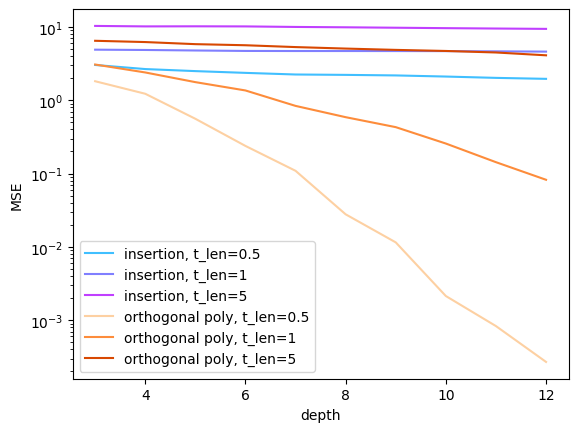

In [36]:
cmap = plt.get_cmap('cool')
c = cmap(np.linspace(0, 1, 5))
for i, t_len in enumerate([0.5, 1, 5]):
    plt.plot(range(3, max_depth+1), errors[0, i], label=f'insertion, t_len={t_len}', color=c[i+1])
cmap = plt.get_cmap('Oranges')
c = cmap(np.linspace(0, 1, 5))
for i, t_len in enumerate([0.5, 1, 5]):
    plt.plot(range(3, max_depth+1), errors[1, i], label=f'orthogonal poly, t_len={t_len}', color=c[i+1])
plt.xlabel('depth')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()

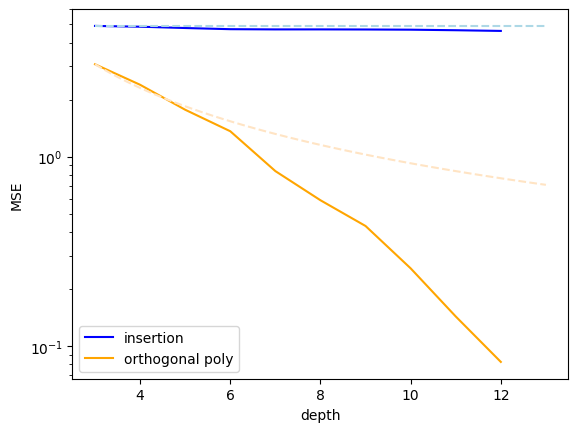

In [37]:
plt.plot(range(3, max_depth+1), errors[0, 1], label=f'insertion', color='blue')
plt.plot(np.linspace(3, max_depth+1, 100), errors[0, 1, 0]*np.ones(100), color='lightblue', linestyle='--')
plt.plot(range(3, max_depth+1), errors[1, 1], label=f'orthogonal poly', color='orange')
plt.plot(np.linspace(3, max_depth+1, 100), 3*errors[1, 1, 0]*np.linspace(3, max_depth+1, 100)**-1, color='bisque', linestyle='--')

plt.xlabel('depth')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()

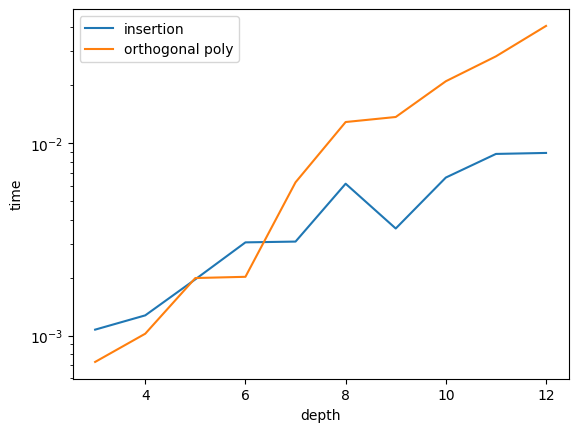

In [38]:
plt.plot(range(3, max_depth+1), time_cost[0, 0], label='insertion')
plt.plot(range(3, max_depth+1), time_cost[1, 0], label='orthogonal poly')
plt.xlabel('depth')
plt.ylabel('time')
plt.yscale('log')
plt.legend()

rough paths

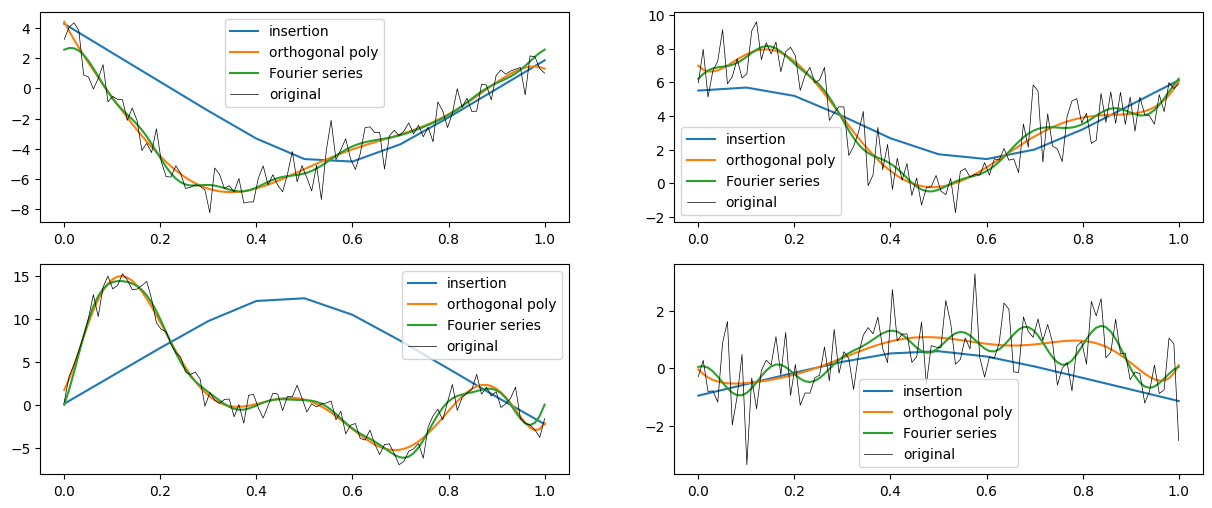

In [41]:
depth = 10
t_grid = np.linspace(0, 1, 100)
plt.figure(figsize=(15, 6))
for i in range(4):
    func1 = random_trig_generator(np.random.randint(1, 10000))
    path = func1(t_grid) + np.random.randn(len(t_grid))
    path_torch = np.stack([t_grid, func1(t_grid)], axis=1)
    path_torch = torch.tensor(path_torch).unsqueeze(0)
    # insertion
    signature = signatory.signature(path_torch, depth)
    recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
    # inversion via Legendre polynomials
    inv1 = Sig2path(pdf_l, t_grid=t_grid)
    rec_o = inv1.path2path(t_grid, path, depth-2) + path[0]
    # inversion via Fourier series
    P = t_grid[-1] - t_grid[0]
    rec_f = fourier2sig(sig(t_grid, path, depth-2), depth-2, t_grid, P, t_grid[0]) + path[0]
    # visualsation
    plt.subplot(2, 2, i+1)
    plt.plot(np.linspace(0, 1, depth+1), np.array(recon_insertion.squeeze(0))[:, 1], label='insertion')
    plt.plot(t_grid, rec_o, label='orthogonal poly')
    plt.plot(t_grid, rec_f, label='Fourier series')
    plt.plot(t_grid, path, color='black', label='original', linewidth=0.5)
    plt.legend()

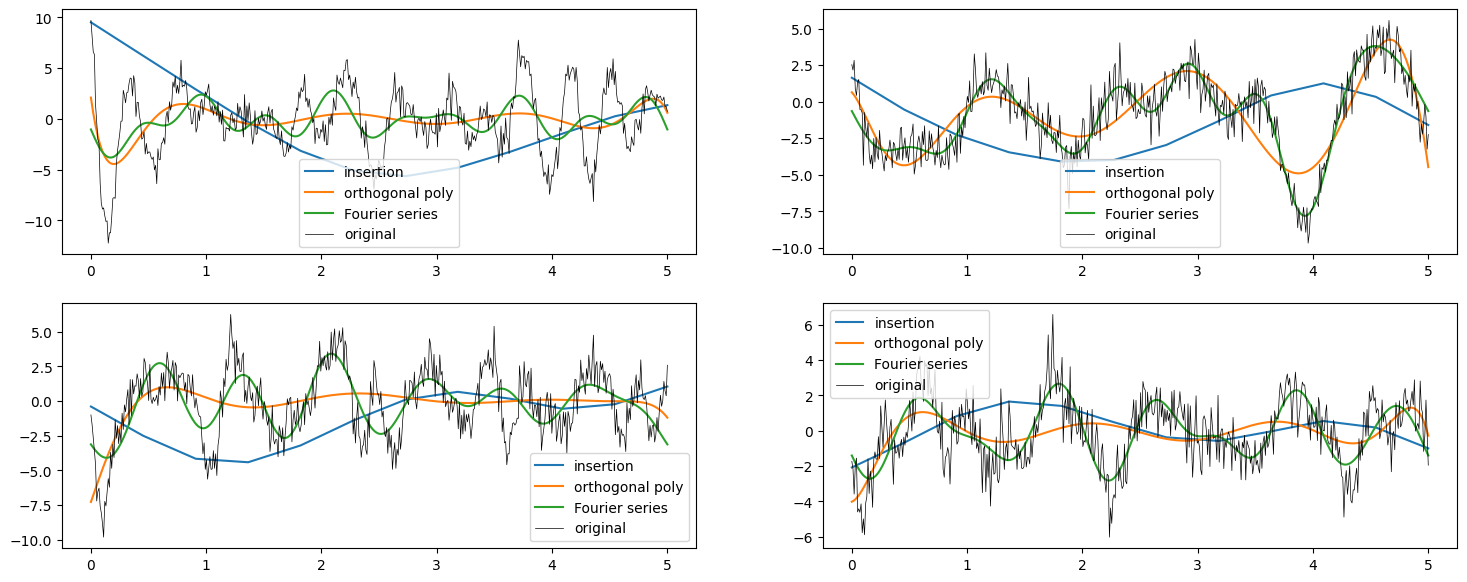

In [46]:
depth = 11
t_grid = np.linspace(0, 5, 500)
plt.figure(figsize=(18, 7))
for i in range(4):
    func1 = random_trig_generator(np.random.randint(1, 10000))
    path = func1(t_grid) + np.random.randn(len(t_grid))
    # path = fbm_generator(1, len(t_grid), hurst=0.9)[0]
    path_torch = np.stack([t_grid, func1(t_grid)], axis=1)
    path_torch = torch.tensor(path_torch).unsqueeze(0)
    # insertion
    signature = signatory.signature(path_torch, depth)
    recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
    # inversion via Legendre polynomials
    inv1 = Sig2path(pdf_l, t_grid=t_grid)
    rec_o = inv1.path2path(t_grid, path, depth-2) + path[0]
    # inversion via Fourier series
    P = t_grid[-1] - t_grid[0]
    rec_f = fourier2sig(sig(t_grid, path, depth-2), depth-2, t_grid, P, t_grid[0]) + path[0]
    # visualsation
    plt.subplot(2, 2, i+1)
    plt.plot(np.linspace(0, 5, depth+1), np.array(recon_insertion.squeeze(0))[:, 1], label='insertion')
    plt.plot(t_grid, rec_o, label='orthogonal poly')
    plt.plot(t_grid, rec_f, label='Fourier series')
    plt.plot(t_grid, path, color='black', label='original', linewidth=0.5)
    plt.legend()